In [1]:
# Imports
import fastfusion as ff
from IPython.display import display
import os
import pkgutil
import importlib
import types
from collections import defaultdict

ff.set_n_parallel_jobs(1, print_message=True)

importlib.reload(ff)


import time
import functools
import inspect
import matplotlib.pyplot as plt
import fastfusion

Using 1 parallel job


In [2]:

# --- Profiler setup ---
timings = {}
total_time = 0.0
orig_funcs = {}
actively_hooked_functions = set()

def hook_function(module, func_name, group_name):
    """Wraps a function in the given module to record execution time."""
    if getattr(getattr(module, func_name), "_hooked_function", False):
        return False

    try:
        func = getattr(module, func_name)
    except AttributeError:
        return False

    if not callable(func):
        return False

    @functools.wraps(func)
    def wrapped(*args, **kwargs):
        if func_name in actively_hooked_functions:
            return func(*args, **kwargs)
        actively_hooked_functions.add(func_name)
        start = time.perf_counter()
        try:
            return func(*args, **kwargs)
        finally:
            actively_hooked_functions.remove(func_name)
            elapsed = time.perf_counter() - start

            target = timings
            key = group_name
            if isinstance(group_name, tuple):
                for n in group_name[:-1]:
                    target = target.setdefault(n, {})
                key = group_name[-1]
            target.setdefault(key, 0.0)
            target[key] += elapsed
    wrapped._hooked_function = True

    setattr(module, func_name, wrapped)
    orig_funcs[func_name] = func
    print(f"Hooked {func_name}")
    return True

def unhook(hook_targets):
    for module_path, funcs in hook_targets.items():
        mod = importlib.import_module(module_path)
        for f in funcs:
            setattr(mod, f, orig_funcs[f])

def recursive_hook(module, names_to_hook):
    """
    Recursively walk all submodules of 'module' and hook functions
    whose names are in 'names_to_hook'.
    """
    for attr_name in dir(module):
        try:
            attr = getattr(module, attr_name)
        except Exception:
            continue

        # Hook if it's a function and matches the target names
        if isinstance(attr, types.FunctionType) and attr.__name__ in names_to_hook:
            hook_function(module, attr.__name__, names_to_hook[attr.__name__])
            print(f"Hooked {attr.__name__}")

        # Recurse into submodules
        elif isinstance(attr, types.ModuleType) and attr.__name__.startswith(module.__name__):
            recursive_hook(attr, names_to_hook)

        # If it's a class, recurse into its methods
        elif isinstance(attr, type):
            for method_name in dir(attr):
                method = getattr(attr, method_name)
                if isinstance(method, types.FunctionType) and method.__name__ in names_to_hook:
                    hook_function(attr, method.__name__, names_to_hook[method.__name__])
                if method_name == "__init__" and attr.__name__ in names_to_hook:
                    hook_function(attr, method_name, names_to_hook[attr.__name__])

    # Also recurse into submodules discovered via pkgutil
    if hasattr(module, "__path__"):
        for loader, subname, ispkg in pkgutil.iter_modules(module.__path__):
            full_name = f"{module.__name__}.{subname}"
            try:
                submod = importlib.import_module(full_name)
            except Exception:
                continue
            recursive_hook(submod, names_to_hook)


# # Flatten the hook_targets dictionary to just a list of function names
# functions_to_hook = [
#     # "makepareto",
#     # "makepareto_numpy",
#     # "eval_objective",
#     # "get_jobs",
#     # "partition_formula",
#     # "coalesce_symbols",
#     # "run_model",

#     "calculate_component_energy_area",
#     "flatten_architecture",
#     "get_jobs",
#     "_fill_jobs_with_memories_to_track",
#     "_allocate_jobs",
#     "combine_combineable",

#     # "make_pmappings_from_templates",
#     "multiply_n_pmappings_by_permutations",
#     "concat",
#     "makepareto",
#     "assert_all_jobs_have_same_symbols",
#     "get_fused_loop_indices",
#     "shift_reservations_by_null_loop_indices",
#     "PmappingDataframe",

#     # "make_tile_shapes",
#     "run_model",
#     "from_pmapping_and_shape",
#     "get_rank_var_to_fused_loops",
#     "Objective",
#     "compile_dict",
#     "call_compiled_objective",



#     # "get_tile_shape_choices",
#     "makepareto_numpy",
#     "eval_objective",
#     "partition_formula",
#     "coalesce_symbols",
# ]

SYMBOLIC_MODEL_NAME = "Full Model"

functions_to_hook = {
    "Mapper": {
        "Other": [
            "combine_combineable",
            "multiply_n_pmappings_by_permutations",
            "assert_all_jobs_have_same_symbols",
            "get_fused_loop_indices",
            "shift_reservations_by_null_loop_indices",
            "from_pmapping_and_shape", # Symbol value relations
            "get_rank_var_to_fused_loops",

            # Process input spec
            "calculate_component_energy_area",
            "flatten_architecture",

            # Generate Pmapping Templates
            "get_jobs",
            "_fill_jobs_with_memories_to_track",
            "_allocate_jobs",
        ],
        "Prune\nMappings": [
            "concat",
            "makepareto",
            "makepareto_numpy",
            "PmappingDataframe",
            "paretoset_attack_defend_grouped_dirty",
        ],
        "Make Pruning\nCriteria": [
            "compile_dict",
            "Objective",
            "partition_formula",
            "coalesce_symbols",
            "function_range",
        ],
        "Misc": []
    },
    "Model": {
        SYMBOLIC_MODEL_NAME: [
            "run_model"
        ],
        "Curried\nModel": [
            "call_compiled_objective",
            "eval_objective",
        ],
    },
}

f2hook_transposed = {}
for k, v in functions_to_hook.items():
    for k2, v2 in v.items():
        for v3 in v2:
            f2hook_transposed[v3] = (k, k2)

recursive_hook(fastfusion, f2hook_transposed)


ff.set_n_parallel_jobs(1, print_message=True)

BATCH_SIZE = 64
N_TOKENS = 65536

# --- Start profiling ---
spec = ff.Spec.from_yaml(
    "../../examples/arches/tpu_v4i_like.arch.yaml",
    "../../examples/workloads/gpt3_6.7B.workload.yaml",
    jinja_parse_data=dict(
        BATCH_SIZE=BATCH_SIZE,
        N_TOKENS=N_TOKENS,
    )
)
spec.arch["ArrayDummy"].constraints.spatial["reuse_input"].min_utilization = 0
spec.arch["ArrayDummy"].constraints.spatial["reuse_output"].min_utilization = 0
spec.arch["MainMemory"].constraints.tensors.keep = "All"
spec.arch.nodes["LocalBuffer"].constraints.tensors.keep = "input | output"
spec.arch.nodes["GlobalBuffer"].constraints.tensors.keep = "input | output"

# spec.arch.nodes["MainMemory"].constraints.tensors.keep = "All"
# spec.arch.nodes["GlobalBuffer"].constraints.tensors.keep = "All"
spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY | ff.mapper.FFM.Metrics.LATENCY

# Start profiling
recursive_hook(fastfusion, functions_to_hook)
prof_start = time.perf_counter()
# pmappings = ff.mapper.FFM.make_pmappings(
#     spec,
#     can_combine_multiple_runs=False,
#     einsum_names=["QK"]
# )
import cProfile
import pstats
import io

# Original code:
pmappings = ff.mapper.FFM.make_pmappings(
    spec,
    can_combine_multiple_runs=False,
    einsum_names=["QK"]
)

# Profiling wrapper
# def profile_make_pmappings(spec):
#     pr = cProfile.Profile()
#     pr.enable()

#     pmappings = ff.mapper.FFM.make_pmappings(
#         spec,
#         can_combine_multiple_runs=False,
#         einsum_names=["QK"]
#     )

#     pr.disable()
#     s = io.StringIO()
#     ps = pstats.Stats(pr, stream=s).sort_stats("cumulative")
#     ps.print_stats(20)  # top 20 by cumulative time
#     print(s.getvalue())
#     return pmappings

# # Use like this
# pmappings = profile_make_pmappings(spec)

prof_end = time.perf_counter()
# unhook(hook_targets)
total_time = prof_end - prof_start

# --- Compute and plot results ---
tracked_time = sum(sum(v.values()) for v in timings.values())
# timings["Mapper"]["Misc"] = max(total_time - tracked_time, 0.0)
timings = dict(timings)

Hooked calculate_component_energy_area
Hooked combine_combineable
Hooked concat
Hooked __init__
Hooked concat
Hooked makepareto
Hooked makepareto
Hooked makepareto
Hooked _allocate_jobs
Hooked _allocate_jobs
Hooked _fill_jobs_with_memories_to_track
Hooked _fill_jobs_with_memories_to_track
Hooked get_jobs
Hooked get_jobs
Hooked __init__
Hooked from_pmapping_and_shape
Hooked call_compiled_objective
Hooked call_compiled_objective
Hooked coalesce_symbols
Hooked coalesce_symbols
Hooked compile_dict
Hooked compile_dict
Hooked get_rank_var_to_fused_loops
Hooked get_rank_var_to_fused_loops
Hooked makepareto_numpy
Hooked makepareto_numpy
Hooked partition_formula
Hooked partition_formula
Hooked run_model
Hooked run_model
Hooked run_model
Hooked run_model
Hooked assert_all_jobs_have_same_symbols
Hooked assert_all_jobs_have_same_symbols
Hooked get_fused_loop_indices
Hooked get_fused_loop_indices
Hooked makepareto
Hooked makepareto
Hooked multiply_n_pmappings_by_permutations
Hooked multiply_n_pmapp

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Hooked makepareto
Hooked makepareto
Using 1 parallel job
Hooked __init__


Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK: 16it [00:00, 50.00it/s]
Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]
WARNING Einsum QK has 16 pmapping templates:
WARNING 	[QK,Q,K in MainMemory] T-b,e,h,m  [Q in GlobalBuffer] T-p  [QK in GlobalBuffer] T-e  S-Z-b,e,h,m,p  [Q in LocalBuffer] T-p  [QK in LocalBuffer] T-e  S-reuse_output-e  S-reuse_input-p  [K in Register] T-m  MAC computes QK
WARNING 	[QK,Q,K in MainMemory] T-b,e,h,m  [Q in GlobalBuffer] T-p  [QK in GlobalBuffer] S-Z-b,e,h,m,p  [QK in LocalBuffer] T-e  [Q in LocalBuffer] T-p  S-reuse_output-e  S-reuse_input-p  [K in Register] T-m  MAC computes QK
WARNING 	[QK,Q,K in MainMemory] T-b,h,m,p  [QK in GlobalBuffer] T-e  [Q in GlobalBuffer] S-Z-b,e,h,m,p  [Q in LocalBuffer] T-p  [QK in LocalBuffer] T-e  S-reuse_output-e  S-reuse_input-p  [K in Register] T-m  MAC computes QK
WARNING 	[QK,Q,K in MainMemory] T-b,h,m,p  [QK i

QK: 1.53e11 total, 5.59e09 (1/27) valid, 1.97e06 (1/7.77e04) evaluated, 2 (1/7.66e10) Pareto-Optimal
Total: 1.53e11 total, 5.59e09 (1/27) valid, 1.97e06 (1/7.77e04) evaluated, 2 (1/7.66e10) Pareto-Optimal


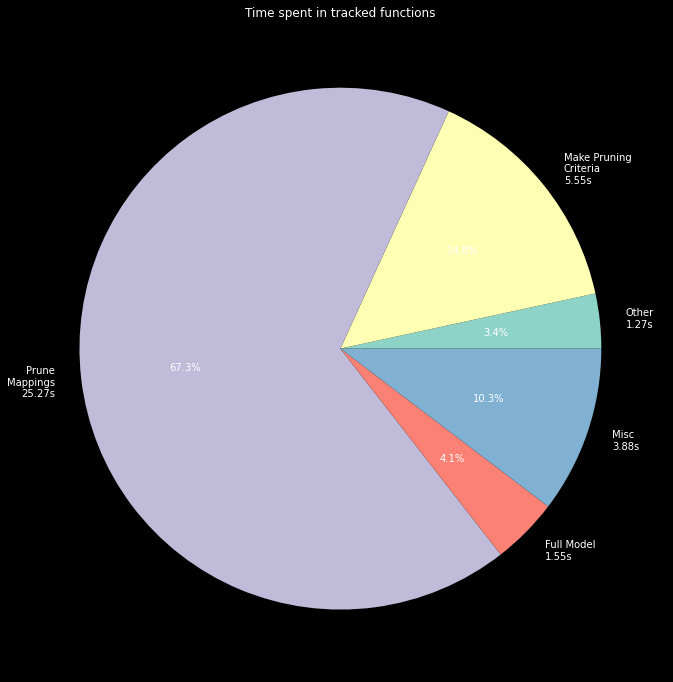

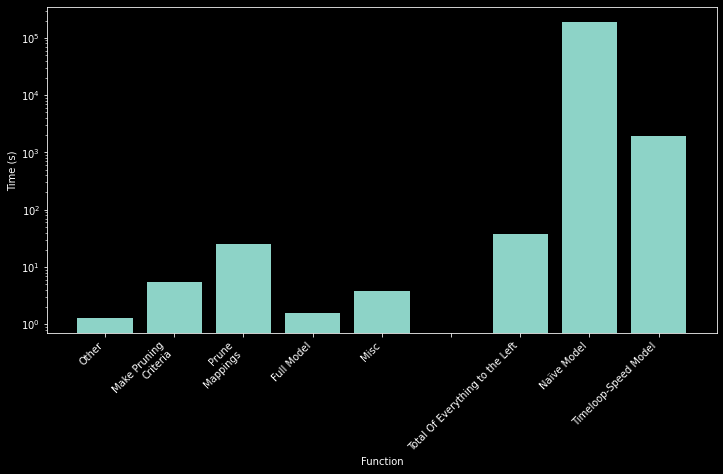

In [3]:
timings_plot = {k: v for k, v in timings["Mapper"].items()}
timings_plot[SYMBOLIC_MODEL_NAME] = timings["Model"][SYMBOLIC_MODEL_NAME]
timings_plot["Misc"] = max(total_time - tracked_time, 0.0)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.pie(
    timings_plot.values(),
    labels=[f"{k}\n{v:.2f}s" for k, v in timings_plot.items()],
    autopct=lambda pct: f"{pct:.1f}%",
)
ax.set_title("Time spent in tracked functions")


# timings2 = {k: v for k, v in timings.items()}
n_jobs = sum(len(jobs) for jobs in pmappings.einsum2jobs.values())
time_per_symbolic_call = timings["Model"][SYMBOLIC_MODEL_NAME] / n_jobs
n_model_calls = pmappings.evaluated_pmappings(per_einsum=False)
# timings2["Curried\nModel"] = time_per_symbolic_call * n_model_calls
plt.show()



# Now we're going to do a bar chart. Want a grouped bar chart. Y axis log scale.

# Have a bar for each function, then a gap, then compiled model, then compiled model
# with the longer runtime

new = {k: v for k, v in timings_plot.items()}
new[" "] = 0
new["Total Of Everything to the Left"] = sum(new.values())
new["Naïve Model"] = time_per_symbolic_call * n_model_calls
new["Timeloop-Speed Model"] = 0.001 * n_model_calls
plt.figure(figsize=(12, 6))
plt.bar(new.keys(), new.values())
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.ylabel("Time (s)")
plt.xlabel("Function")
plt.show()

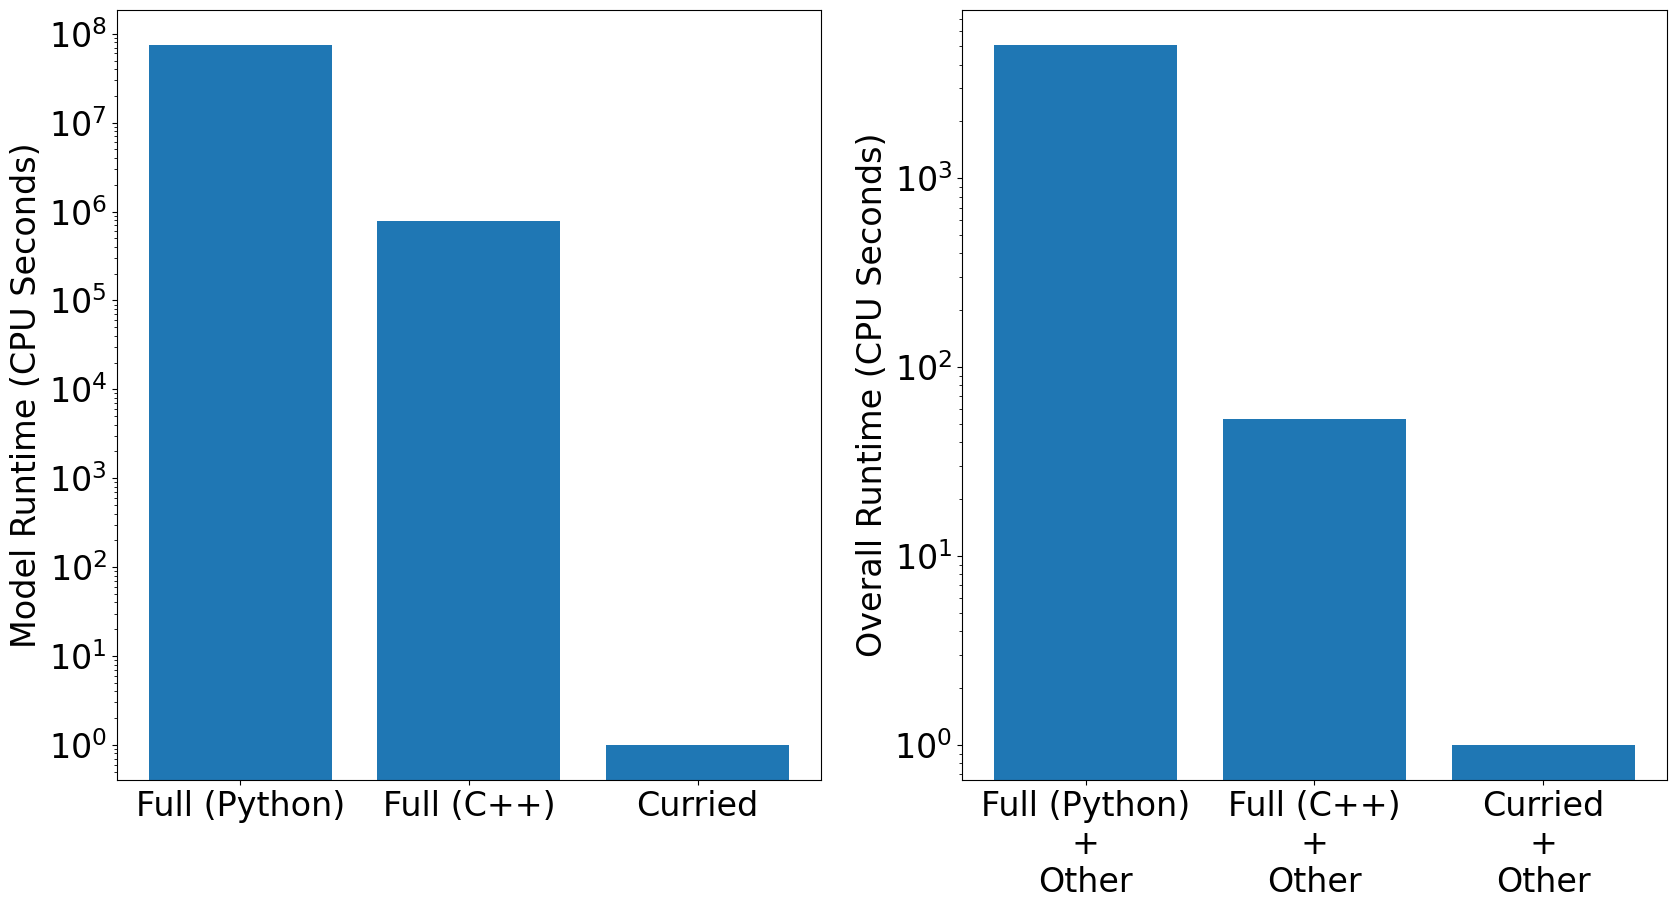

In [4]:
import matplotlib.pyplot as plt
from format_plot import format_plot

def make_stacked_bar_chart(
    results: dict[str, dict[str, float]],
    ax: plt.Axes
):
    categories = list(next(iter(results.values())).keys())
    labels = list(results.keys())
    data = list(zip(*results.values()))
    bottom = [0] * len(labels)
    for i, cat in enumerate(categories):
        ax.bar(labels, [results[l][cat] for l in labels], label=cat, bottom=bottom)
        bottom = [b + v for b, v in zip(bottom, [results[l][cat] for l in labels])]
    format_plot(ax)
    # Set the Y axis label to be 10^x
    ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
    ax.set_xticklabels(labels, rotation=45, ha="right")

fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
# plt.subplots_adjust(wspace=0.5)

ax = axs[0]
plt.rcParams.update({'font.size': 24})

# # Runtime breakdown pie chart
# ax = axs[2]
# ax.pie(
#     timings.values(),
#     labels=[f"{k}\n{v:.1f}s" for k, v in timings.items()],
#     autopct=lambda pct: f"{pct:.1f}%",
#     startangle=135,
# )
# #  Make a legend instead of labeling the pie
# ax.set_title("Turbo-Charged Runtime Breakdown")


ax = axs[0]
# Overall runtime of:
# - Us
# - Naive model
# - Optimized model
runtimes = {
    "Full (Python)\n": time_per_symbolic_call * n_model_calls,
    "Full (C++)\n": 0.001 * n_model_calls,
    "Curried": timings["Model"]["Curried\nModel"],
}
runtimes = {k: v / runtimes["Curried"] for k, v in runtimes.items()}
ax.bar(runtimes.keys(), runtimes.values())
ax.set_ylabel("Model Runtime (CPU Seconds)")
# ax.set_title("Runtime breakdown")
ax.set_yscale("log")


ax = axs[1]
# Overall runtime of:
# - Us
# - Naive model
# - Optimized model
runtimes = {
    "Full (Python)\n+\nOther": sum(timings_plot.values()) - sum(timings["Model"].values()) + time_per_symbolic_call * n_model_calls,
    "Full (C++)\n+\nOther": sum(timings_plot.values()) - sum(timings["Model"].values()) + 0.001 * n_model_calls,
    "Curried\n+\nOther": sum(timings_plot.values()),
}
runtimes = {k: v / runtimes["Curried\n+\nOther"] for k, v in runtimes.items()}
ax.bar(runtimes.keys(), runtimes.values())
ax.set_ylabel("Overall Runtime (CPU Seconds)")
# ax.set_title("Runtime breakdown")
ax.set_yscale("log")

plt.savefig("outputs/plots/model_speed_compare.pdf", bbox_inches="tight")

# Runtime breakdown bar chart
plt.show()

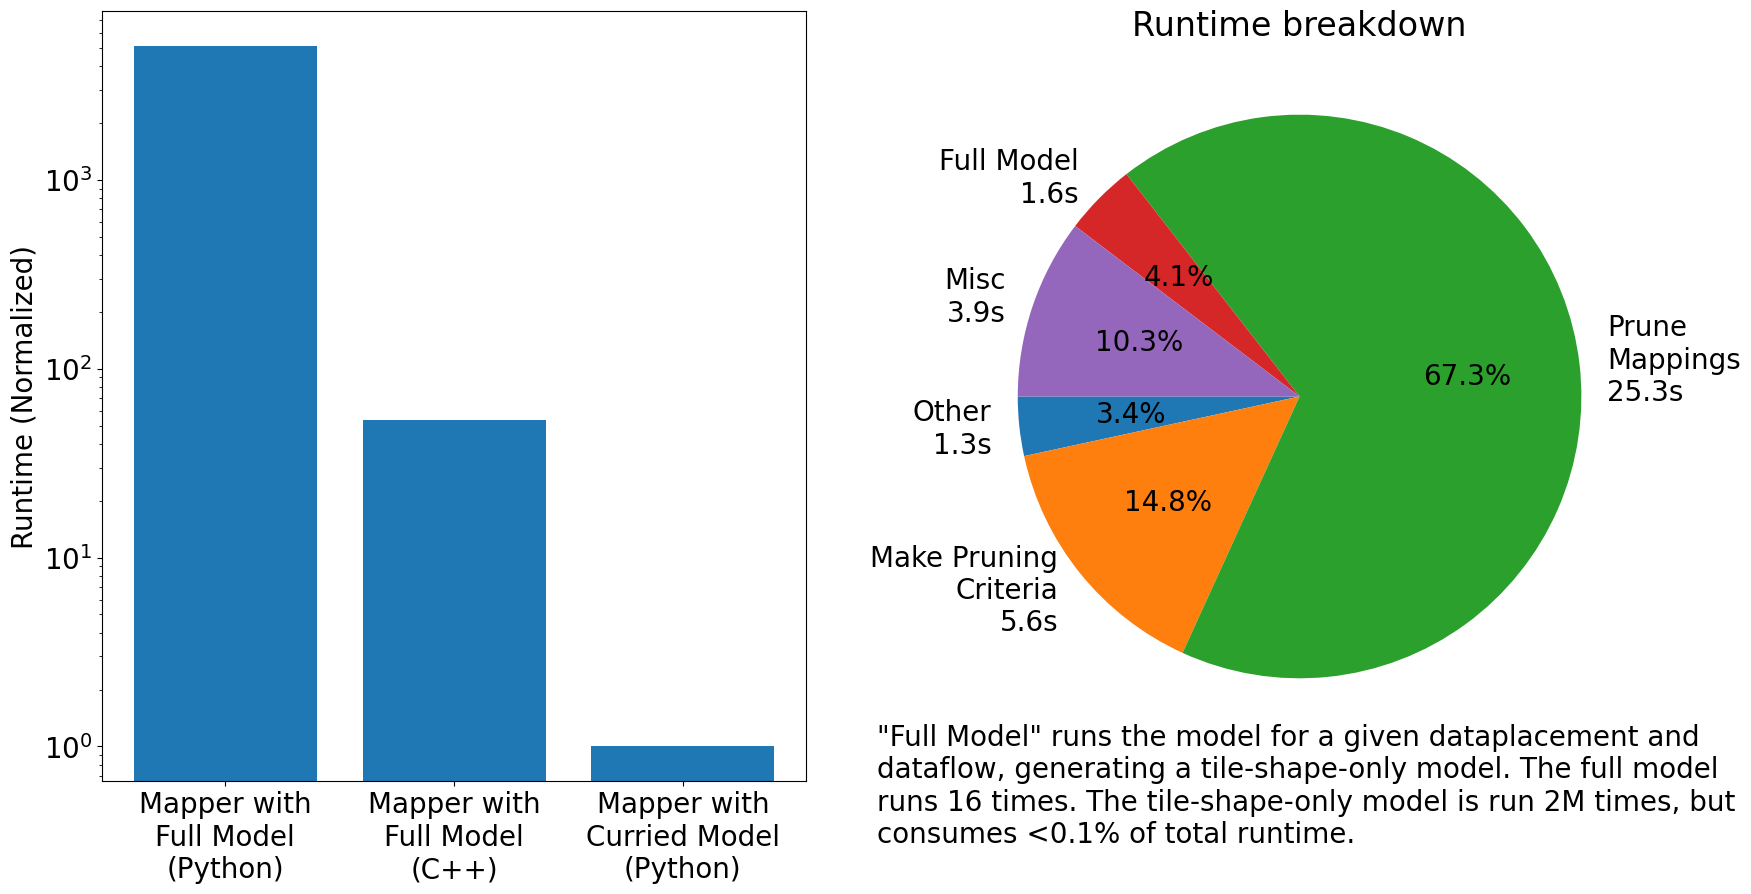

In [ ]:
import matplotlib.pyplot as plt
from format_plot import format_plot

def make_stacked_bar_chart(
    results: dict[str, dict[str, float]],
    ax: plt.Axes
):
    categories = list(next(iter(results.values())).keys())
    labels = list(results.keys())
    data = list(zip(*results.values()))
    bottom = [0] * len(labels)
    for i, cat in enumerate(categories):
        ax.bar(labels, [results[l][cat] for l in labels], label=cat, bottom=bottom)
        bottom = [b + v for b, v in zip(bottom, [results[l][cat] for l in labels])]
    format_plot(ax)
    # Set the Y axis label to be 10^x
    ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
    ax.set_xticklabels(labels, rotation=45, ha="right")

fig, axs = plt.subplots(figsize=(20, 10), ncols=2)

ax = axs[0]
plt.rcParams.update({'font.size': 20})

ax = axs[0]
runtimes = {
    "Mapper with\nFull Model\n(Python)": sum(timings_plot.values()) - sum(timings["Model"].values()) + time_per_symbolic_call * n_model_calls,
    "Mapper with\nFull Model\n(C++)": sum(timings_plot.values()) - sum(timings["Model"].values()) + 0.001 * n_model_calls,
    "Mapper with\nCurried Model\n(Python)": sum(timings_plot.values()),
}
runtimes = {k: v / runtimes["Mapper with\nCurried Model\n(Python)"] for k, v in runtimes.items()}
ax.bar(runtimes.keys(), runtimes.values())
ax.set_ylabel("Runtime (Normalized)")
# ax.set_title("Runtime breakdown")
ax.set_yscale("log")

ax = axs[1]
ax.set_title("Runtime breakdown")
ax.pie(
    timings_plot.values(),
    labels=[f"{k}\n{v:.1f}s" for k, v in timings_plot.items()],
    autopct=lambda pct: f"{pct:.1f}%",
    startangle=180,
)

x = n_jobs
text = f"""
                        "Full Model" runs the model for a given dataplacement and
                        dataflow, generating a tile-shape-only model. The full model
                        runs {x} times. The tile-shape-only model is run 2M times, but
                        consumes <0.1% of total runtime.
""".replace("                        ", "")
ax.text(-1.5, -1.7, text)

plt.savefig("outputs/plots/model_speed_compare.pdf", bbox_inches="tight")

# Runtime breakdown bar chart plt.show()